# <span style='color:black'>**Fully-automated Peak-picking for Autonomous Cable Monitoring**</span>
<center><span style='color:white;background-color:black'>Made by SS Jin (2023.06.13)</span></center>

For more infomration, you can check our publications as below

- SCI/E Paper: [Fully automated peak-picking method for an autonomous stay-cable monitoring system in cable-stayed bridges (2021)](https://www.sciencedirect.com/science/article/pii/S0926580521000790)
- Science News (EurekaAlert!): [AI is not perfect -- Domain knowledge is a key in engineering](https://www.eurekalert.org/news-releases/584646)

## <span style='color:blue'>**_Background #1: Cable-stayed Bridge_**</span>

<center> <p>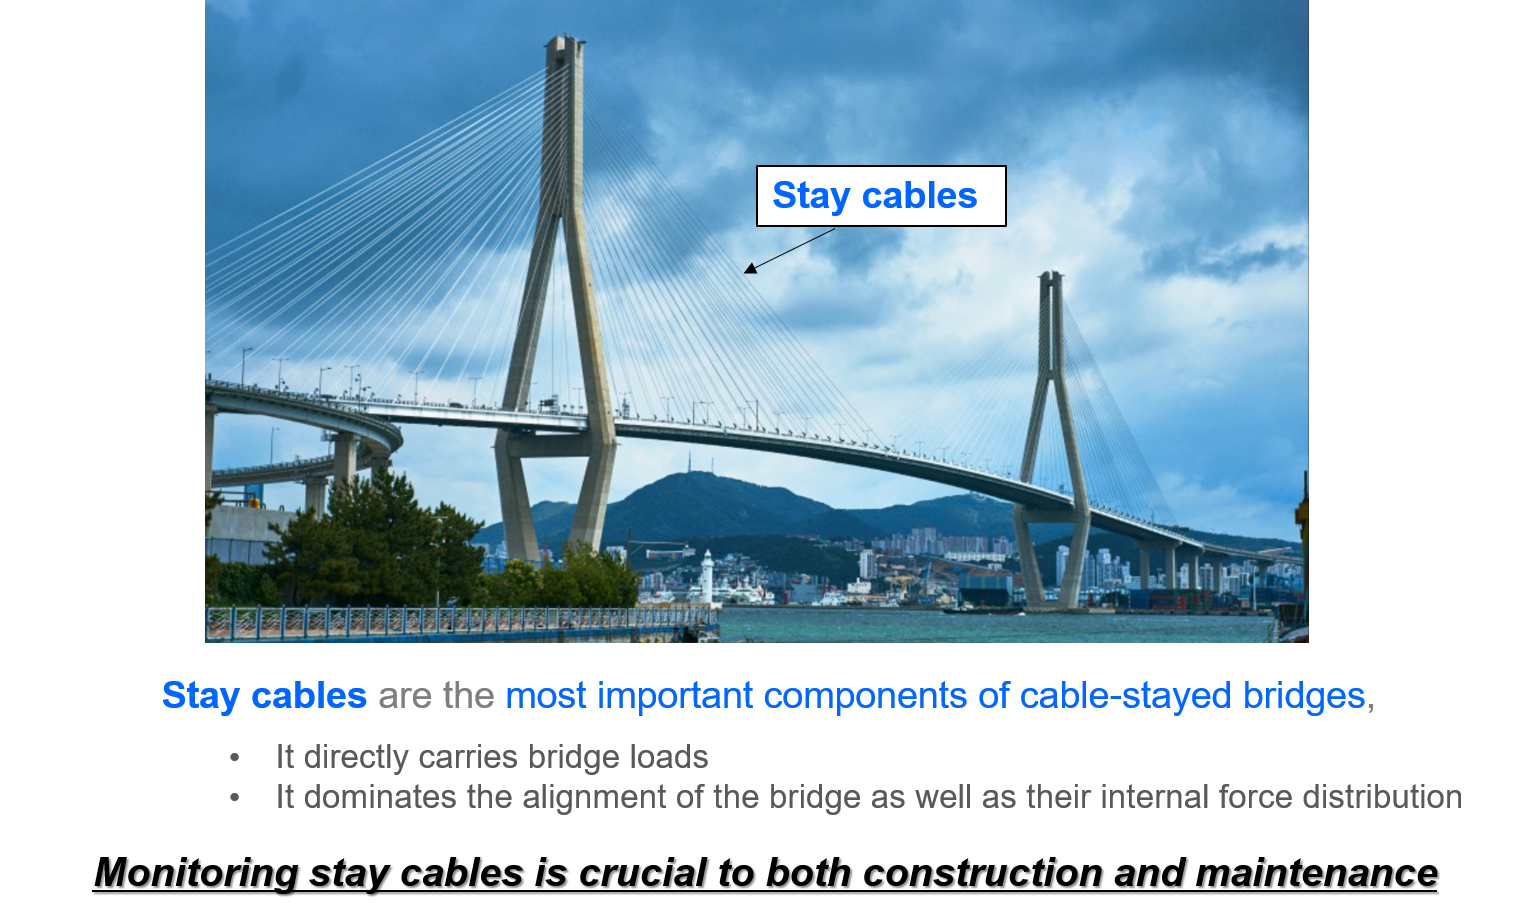</p> </center>

## <span style='color:blue'>**_Background #2: Cable monitoring in Cable-stayed Bridge_**</span>

<center> <p>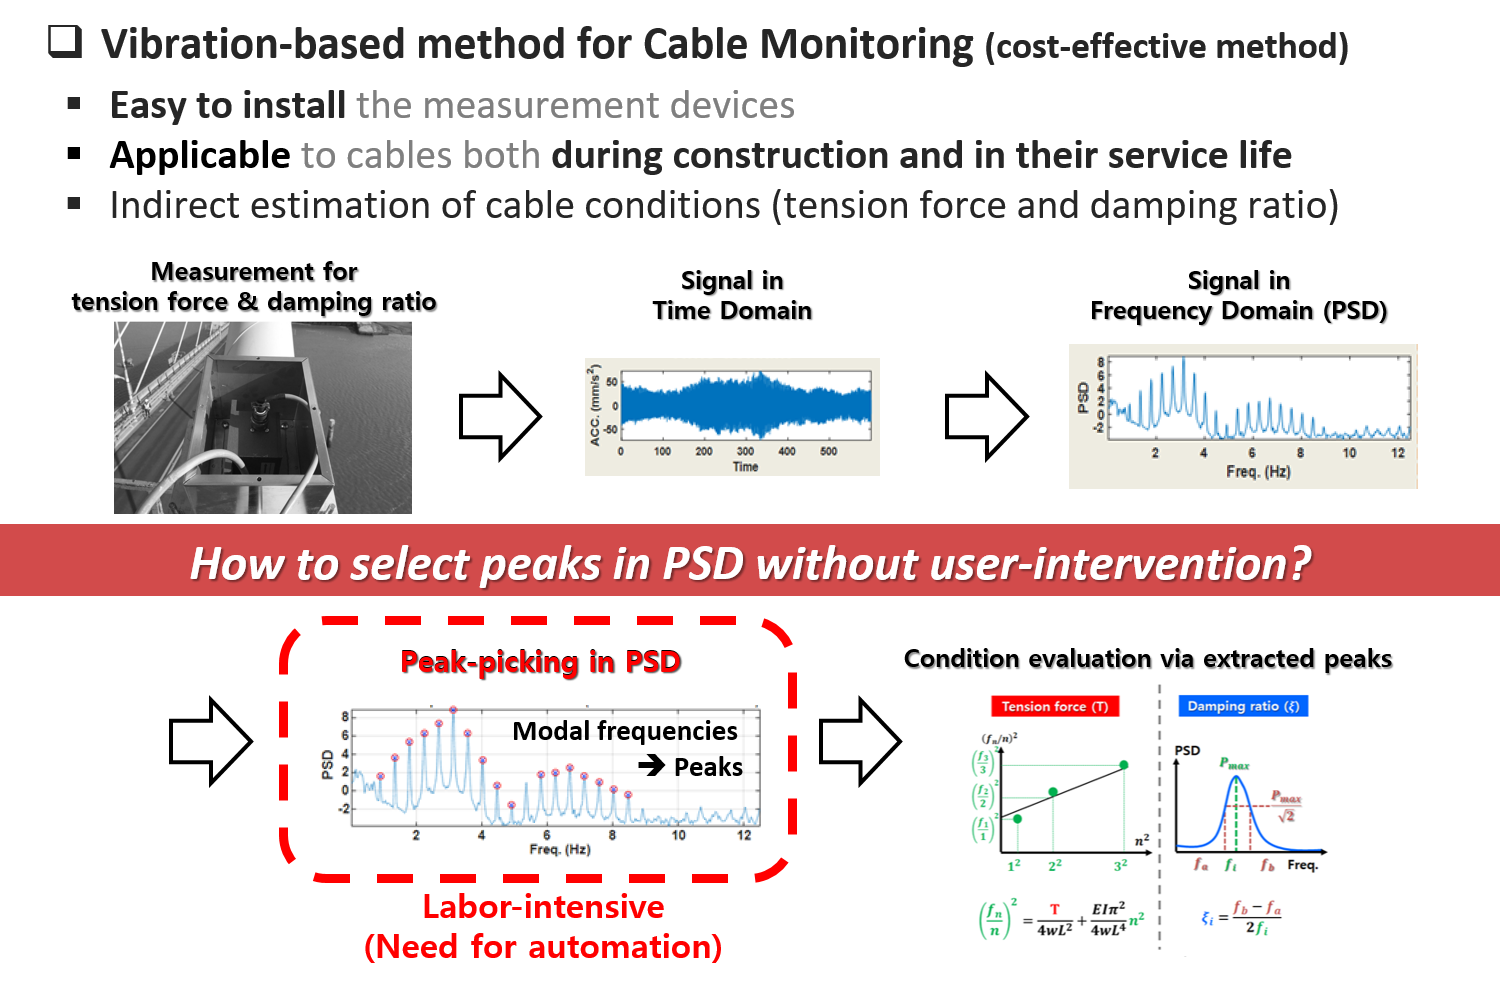</p> </center>

$$
    ...
$$

# <span style='color:black'>**Implementation of `Fully-automated Peak-picking method`**</span>

## <span style='color:black'>**Load libraries**</span>

- AMPD: [pyampd](https://pypi.org/project/pyampd/)
- Baseline Removal: [pybaselines](https://pypi.org/project/pybaselines/)

In [1]:
import pandas as pd
import numpy as np

import shutil
import matplotlib.pyplot as plt

plt.style.use(['dark_background', 'bmh'])
font = {'family' : 'monospace',
        'weight' : 'bold',
        'size'   : 12}
plt.rc('font', **font)
plt.rc('axes', facecolor='k')
plt.rc('figure', facecolor='k')
plt.rc('figure', figsize= (8, 5), dpi=200)

## <span style='color:black'>**1. Load field-data (accelerometer) of `Cable I03` in Hawtae Bridge**</span>
- Sampling Freq. (Hz) = 100 Hz = $100 \frac{pts}{sec}$
- Measurement Durtation = 10 min
- Data points (pts) = 60,000 pts ($= 100 \frac{pts}{sec} \times 60 \frac{sec}{min} \times 10 \frac{min}{1}$)

In [2]:
'''
    VALUES which should be specified by user
    - fs : Sampling freq. (Hz)
'''
# Sampling freq. (Hz)
fs = 100

In [3]:
# Import Rawdata from text-file
df = pd.read_csv('HTB_201701_CAC_I03_light.txt', sep = ' ', header = None)
# df = pd.read_csv('HTB_201701_CAC_I03.txt', sep = ' ', header = None) # File size 1 GB
print(f'# of Datasets: {df.shape[1]}')

# Compute time in seconds
t = np.linspace(0, df.shape[0]/fs, df.shape[0])
df.index = t
df.head()

# of Datasets: 50


0           1           2           3           4   \
0.000000  736.507504  761.414182  781.853857  758.913639  796.396725   
0.010000  735.480848  763.087551  777.379019  755.489261  805.170787   
0.020000  735.568237  763.818424  770.583977  751.582600  811.266718   
0.030001  737.178562  764.367521  762.659998  748.765758  813.056007   
0.040001  741.092640  764.026818  753.532192  746.768015  812.401278   

                  5           6           7           8           9   ...  \
0.000000  761.631907  760.077688  760.848278  763.152031  762.767903  ...   
0.010000  763.006742  761.113196  760.783798  763.359528  763.509064  ...   
0.020000  764.127784  760.993567  760.044012  762.911876  763.307668  ...   
0.030001  764.324514  760.690308  760.465525  762.066519  763.142700  ...   
0.040001  763.297380  760.896368  760.009918  760.956183  761.675392  ...   

                  40          41          42          43          44  \
0.000000  760.760410  760.586111  760.687975  759.992153  760.347332   
0.010000  760.621162  760.985671  760.027683  760.200607  760.573011   
0.020000  760.988004  760.908092  760.026248  760.499679  760.153832   
0.030001  760.866042  761.103865  760.358995  760.278126  760.472523   
0.040001  760.187986  761.452942  761.308550  760.446863  760.308512   

                  45          46          47          48          49  
0.000000  760.519298  760.921132  761.111820  761.466938  760.724402  
0.010000  761.303884  760.450093  761.347310  761.016954  760.437472  
0.020000  760.748746  761.294553  760.679541  760.628160  760.566013  
0.030001  761.056671  760.651548  760.473480  761.287495  760.473480  
0.040001  761.115529  760.909468  761.481892  761.081434  760.401045  

[5 rows x 50 columns]

#### **Plot one of Raw-data**

In [4]:
IND_data = 1
signal = df.iloc[:, IND_data]

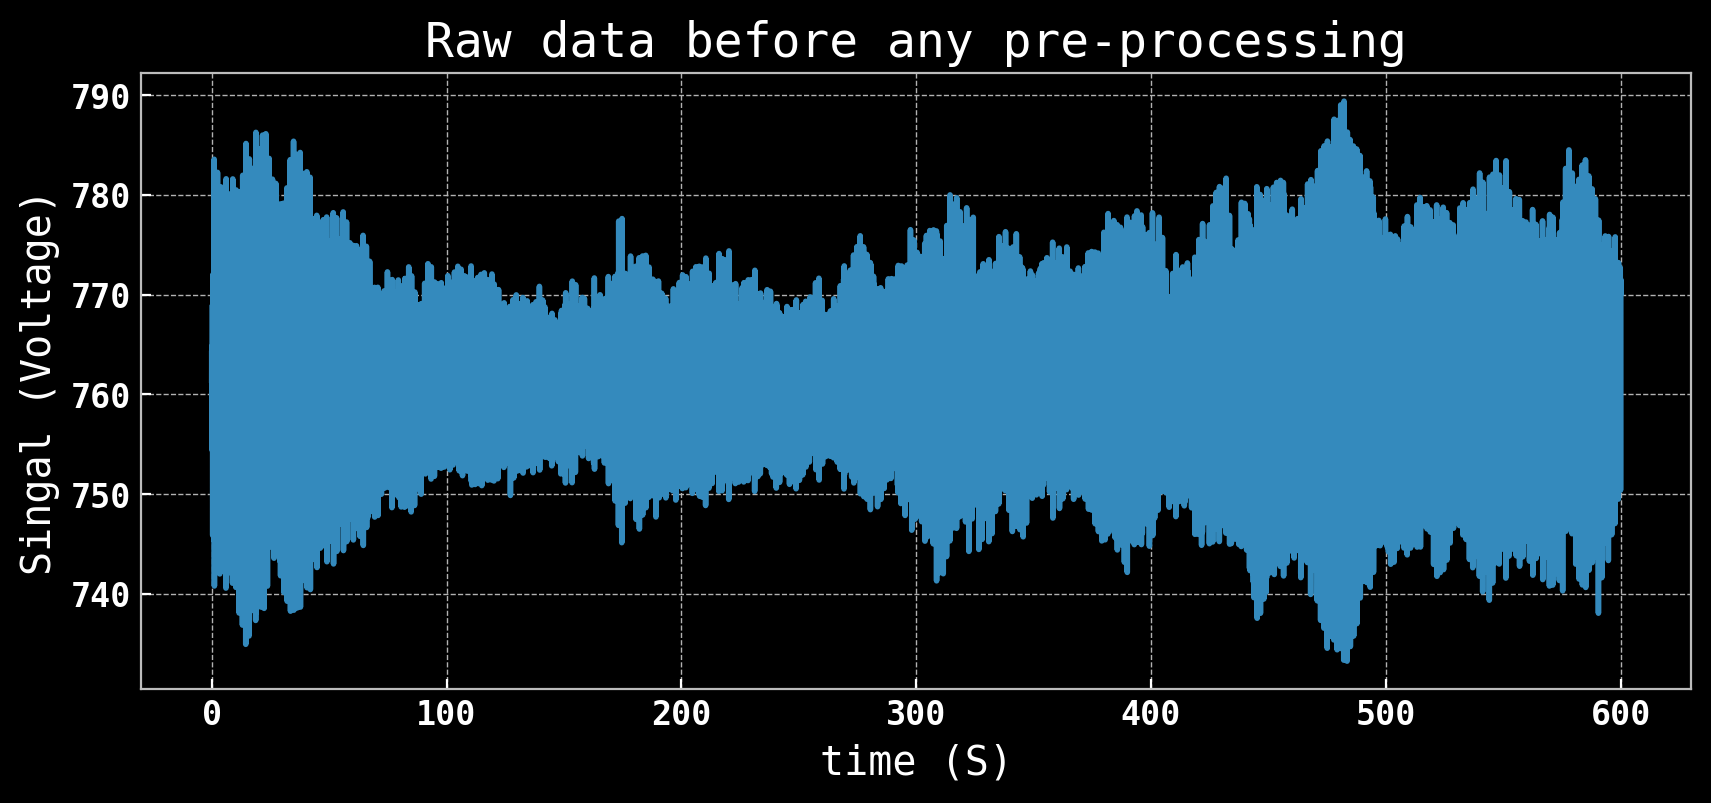

In [5]:
plt.figure(figsize = (10, 4))
plt.plot(df.index, signal)
plt.xlabel('time (S)')
plt.ylabel('Singal (Voltage)')
plt.title('Raw data before any pre-processing')
plt.show()

## <span style='color:black'>**2. Preprocessing**</span>
### **2-1. Preprocessing #1: detrending signal**

Before transforming raw-data into frequency domain, any trend and DC components should be removed using `detrend`

<center> <p>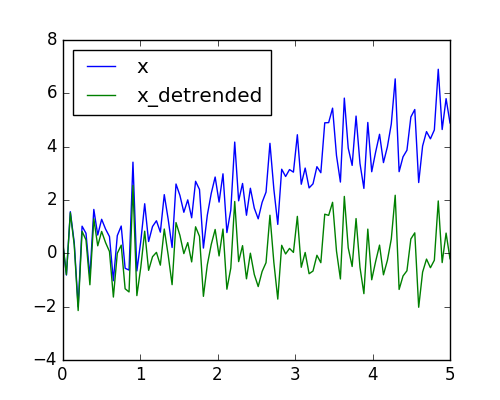</p> </center>

In [6]:
import scipy

def detrend_signal(signal):
    signal_ = scipy.signal.detrend(signal)
    return signal_

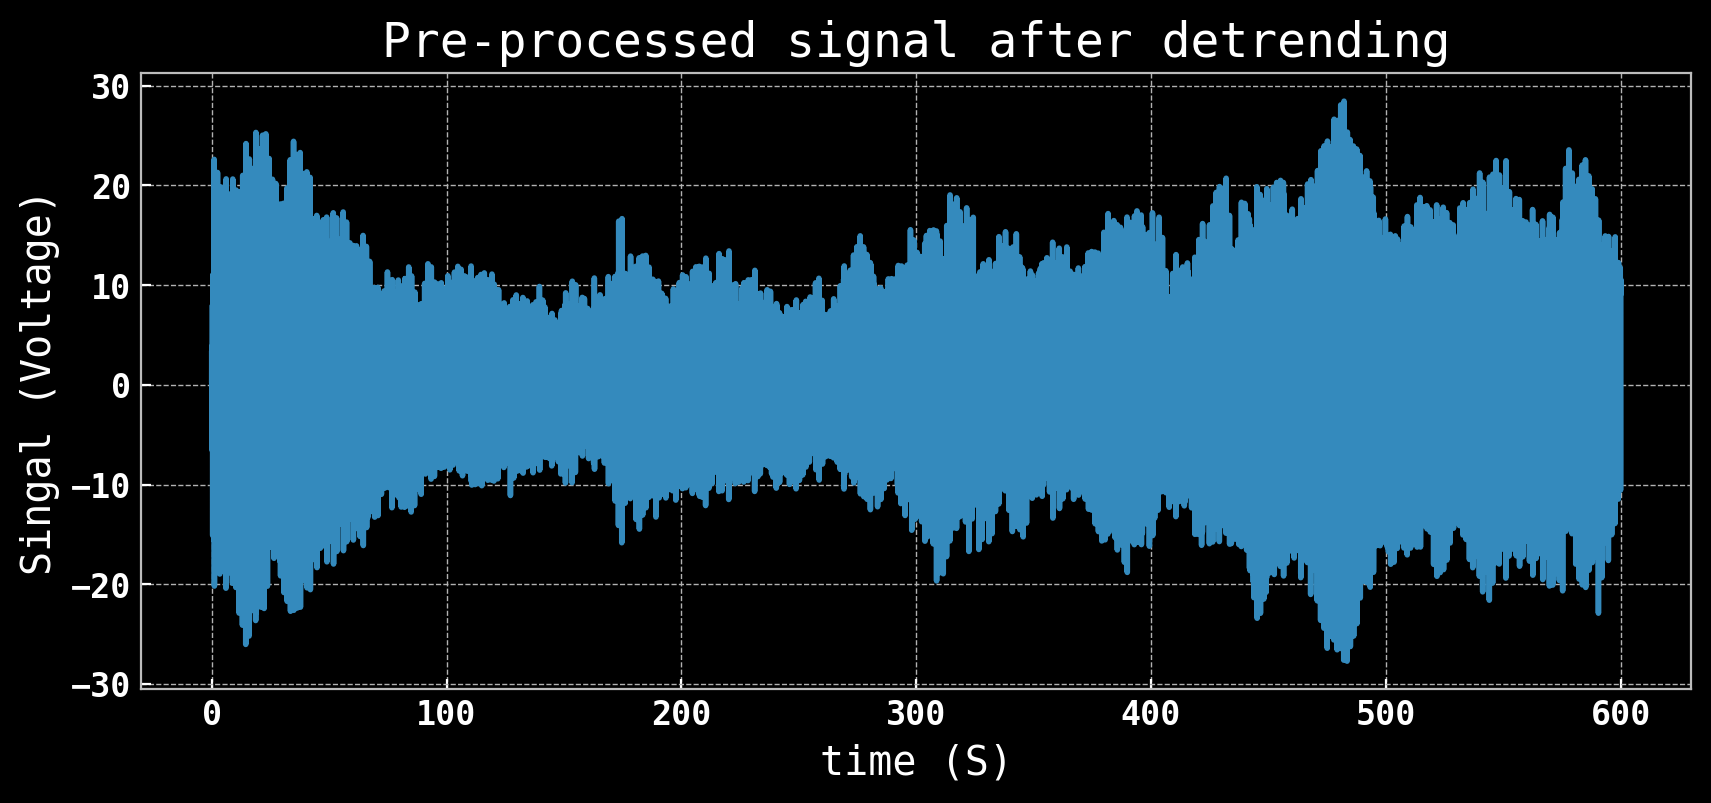

In [7]:
# Detrend signal
signal_detrend = detrend_signal(signal)

# Plot result
plt.figure(figsize = (10, 4))
plt.plot(df.index, signal_detrend)
plt.xlabel('time (S)')
plt.ylabel('Singal (Voltage)')
plt.title('Pre-processed signal after detrending')
plt.show()

### **2-2. Preprocessing #2: Compute Power Spectral Density**

Welch’s method [1] computes an estimate of the power spectral density by dividing the data into overlapping segments, computing a modified periodogram for each segment and averaging the periodograms.

> **User specified options**
```text
    - window: Hann window
    - nperseg: Length of each segment
    - noverlap: 50% => nperseg // 2
    - nfft = 2048
```

for more information, you can refer to [this Doc.](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.welch.html)

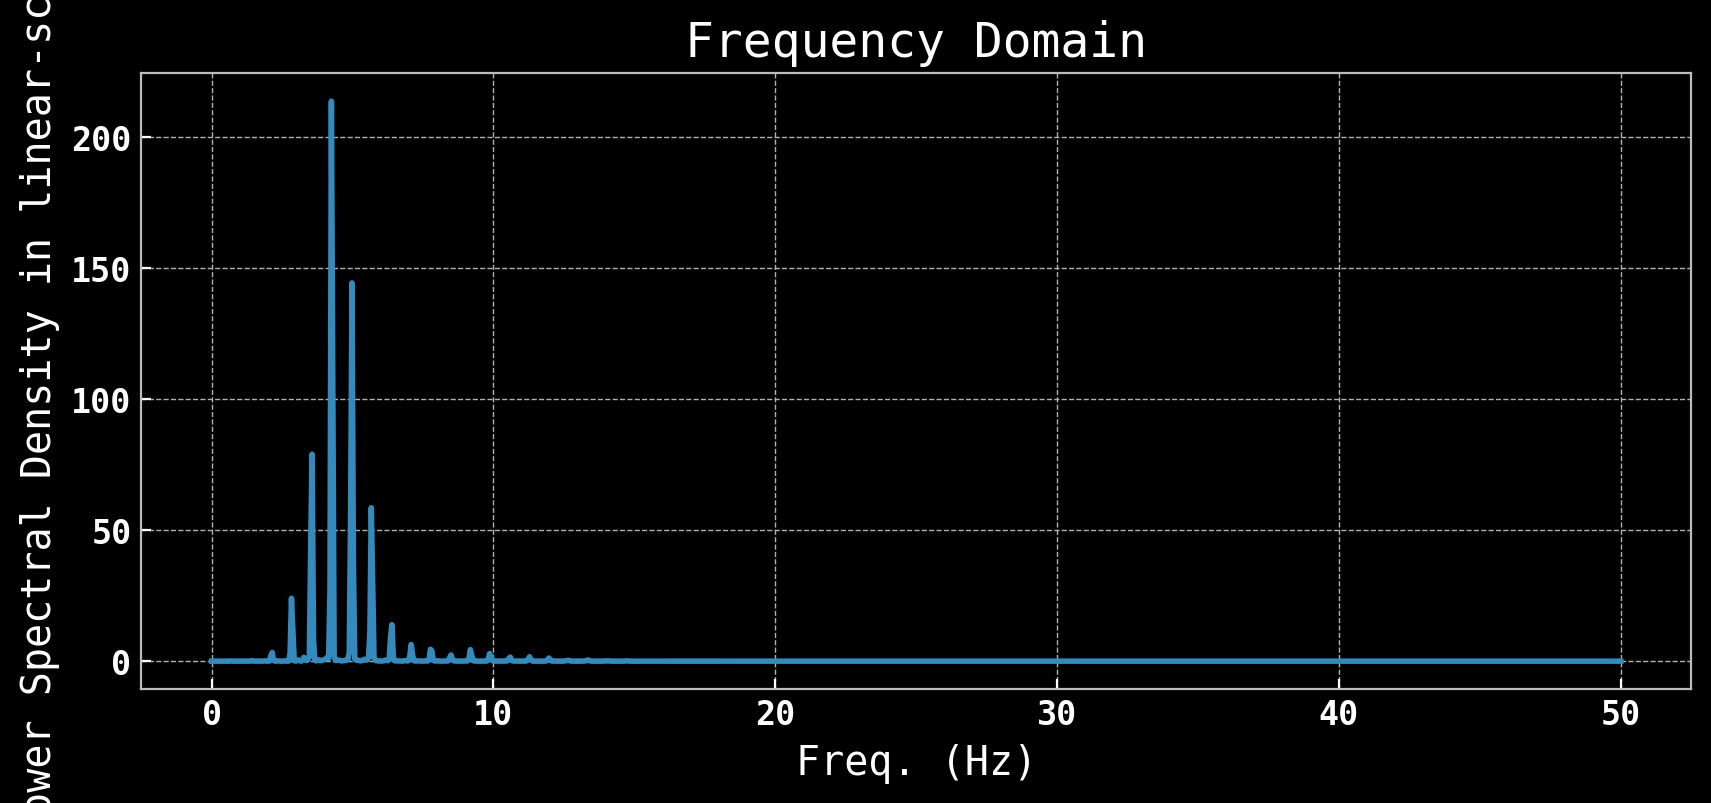

In [8]:
nperseg, nfft = 2048, 2048

# Compute PSD using Welch's method
# Pxx_den: PSD in linear-scale
f, Pxx_den = scipy.signal.welch(signal_detrend, fs = fs, nperseg = nperseg, nfft = nfft)

# Plot result
plt.figure(figsize = (10, 4))
plt.plot(f, Pxx_den)
plt.xlabel('Freq. (Hz)')
plt.ylabel('Power Spectral Density in linear-scale')
plt.title('Frequency Domain')
plt.show()

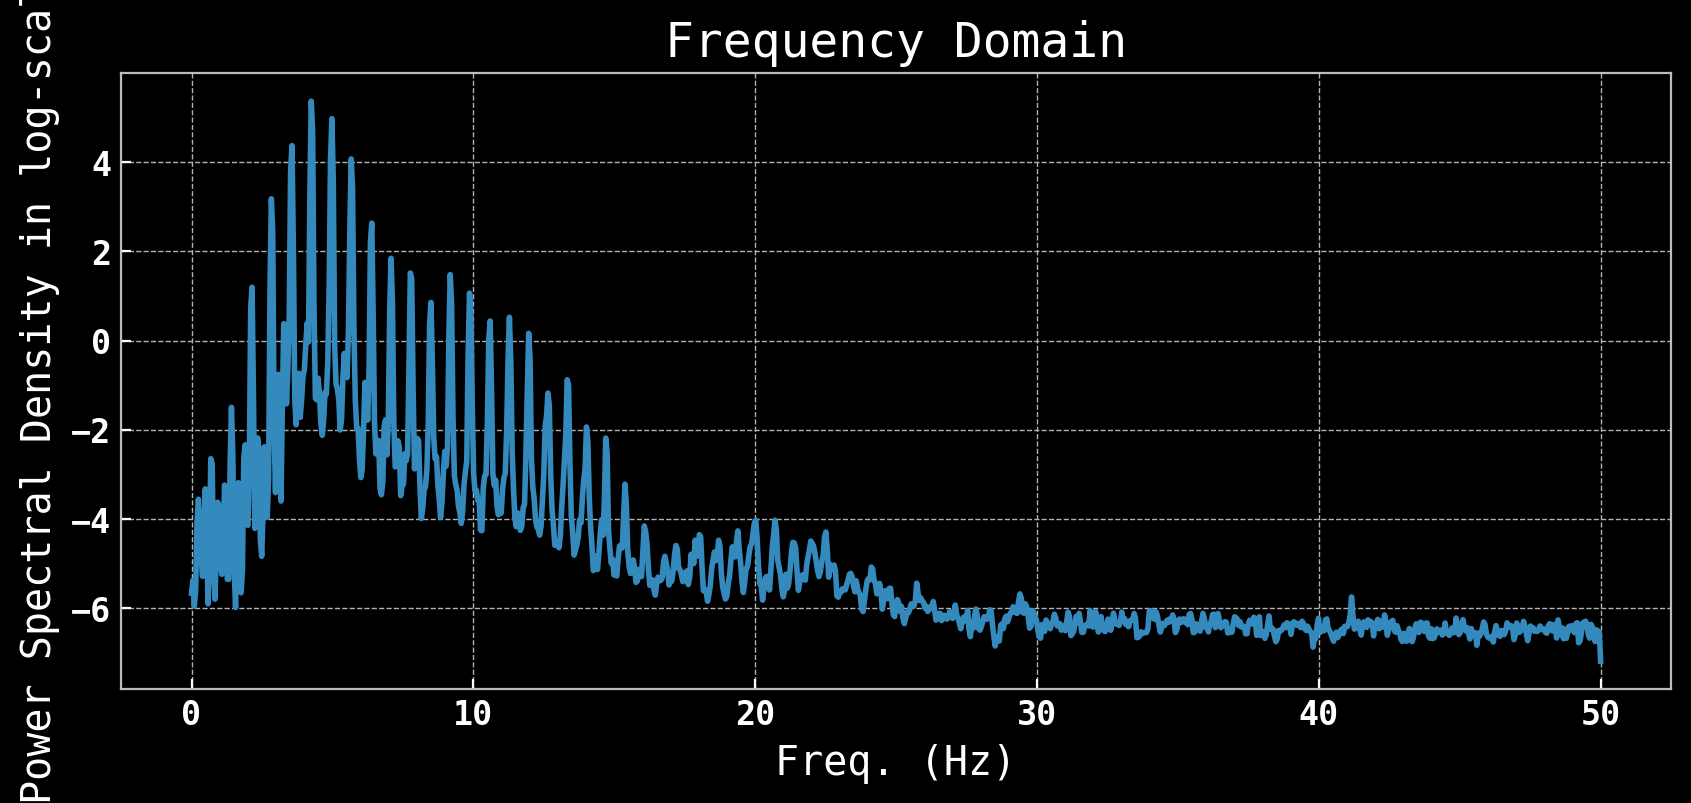

In [9]:
# Take logarithm to PSD to make peak more distinct
# Pxx_log: PSD in log-scale
Pxx_log = np.log(Pxx_den)

# Plot result
plt.figure(figsize = (10, 4))
plt.plot(f, Pxx_log)
plt.xlabel('Freq. (Hz)')
plt.ylabel('Power Spectral Density in log-scale')
plt.title('Frequency Domain')
plt.show()

## <span style='color:black'>**3. Exploit Domain Knowledge: Extract peak information**</span>
### <span style='color:blue'> **_Background #3: Domain knoweldge for Fully-automated peak-picking_**</span>

- <span style='color:red'>**[Perioicity]** The modal frequencies of the stay-cables appear periodically or quasi-periodically</span>
- <span style='color:blue'>**[Well-excited]** The modal frequencies are peak with high-amplitudes like outlier to its neighbors.</span>

<center> <p>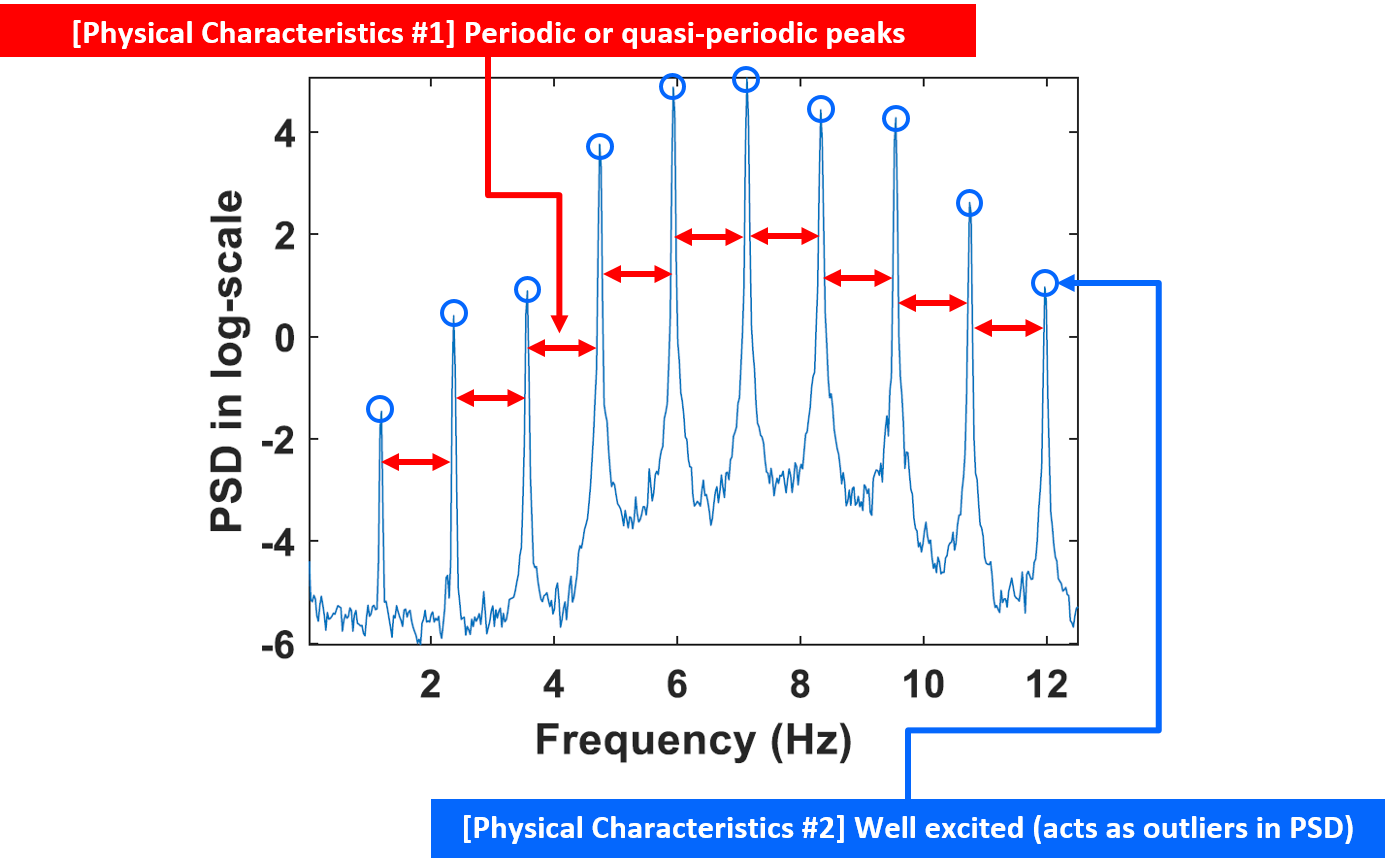</p> </center>

### **4-1. Utilization of Domain Knowledge #1: Periodicity**

- The biomedical discipline is one of the specialized fields for analyzing signals with periodic peaks.
- Our heart-beat makes periodic peaks in ECG signals and we can compute heart rate by counting the periodic peaks in real time.
- We can adopt one of the methods from this discipline to exploit the periodic characteristics of the modal frequencies.

<center> <p>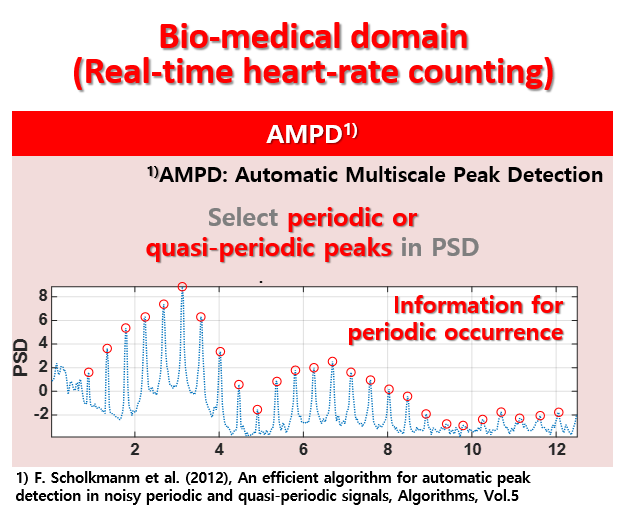</p> </center>

#### **Define function for AMPD implentation**

In [10]:
from pyampd.ampd import find_peaks as find_ampd_peaks

def run_information_integration(Pxx_log):
    '''
    [Input]
        Pxx_log : PSD in log-scale

    [Output]
        peaks_ampd : Indice of periodic peaks
    '''
    # Run AMPD
    peaks_ampd = find_ampd_peaks(Pxx_log)
    return peaks_ampd

#### **Run AMPD to extract possible periodic peaks**

In [11]:
AMPD_ind = run_information_integration(Pxx_log)

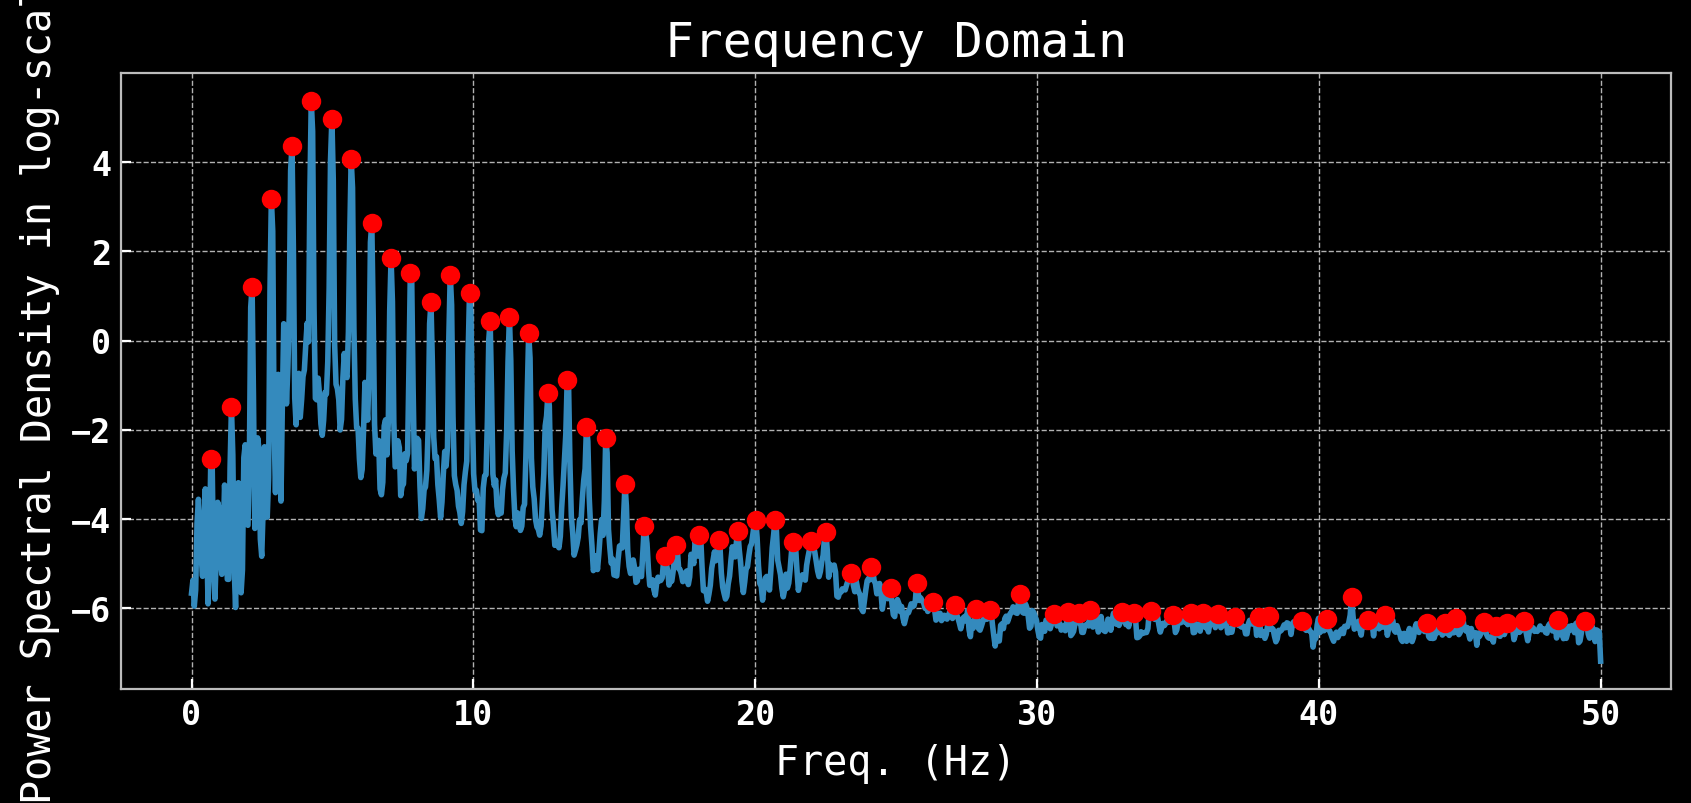

In [12]:
# Plot result
plt.figure(figsize = (10, 4))
plt.plot(f, Pxx_log)
plt.plot(f[AMPD_ind], Pxx_log[AMPD_ind], 'ro')
plt.xlabel('Freq. (Hz)')
plt.ylabel('Power Spectral Density in log-scale')
plt.title('Frequency Domain')
plt.show()

### **4-2. Utilization of Domain Knowledge #2: Outlier behavior**

- Well excited peaks with large amplitude can be extracted by two methods from industrial engineering domain.

- It consists of two steps as (1) Baseline removal and (2) MAD for outlier detection.

<center> <p>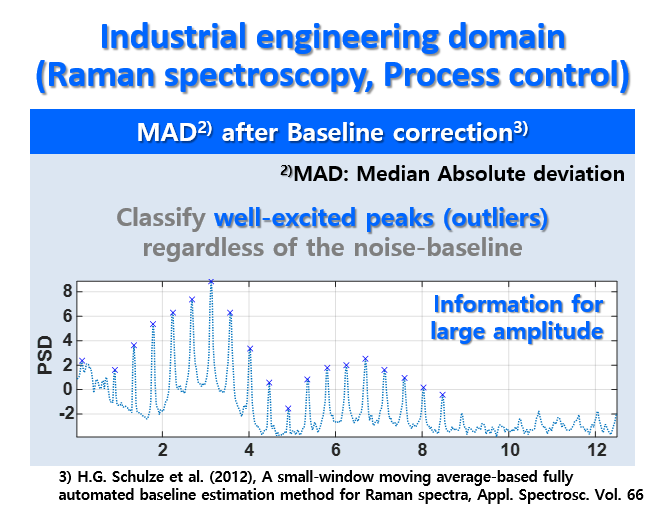</p> </center>

#### **Step #1: Baseline removal**

Define function for baseline removal

In [13]:
from pybaselines.smooth import swima

def run_baseline_correction(Pxx_log):
    '''
    [Input]
        Pxx_log : PSD in log-scale

    [Output]
        Pxx_correct : PSD after Baseline removal
    '''
    baseline = swima(Pxx_log)
    Pxx_correct = Pxx_log - baseline[0]
    return Pxx_correct

#### **Run Baseline removal to remove baselines in PSD**

In [14]:
Pxx_correct = run_baseline_correction(Pxx_log)

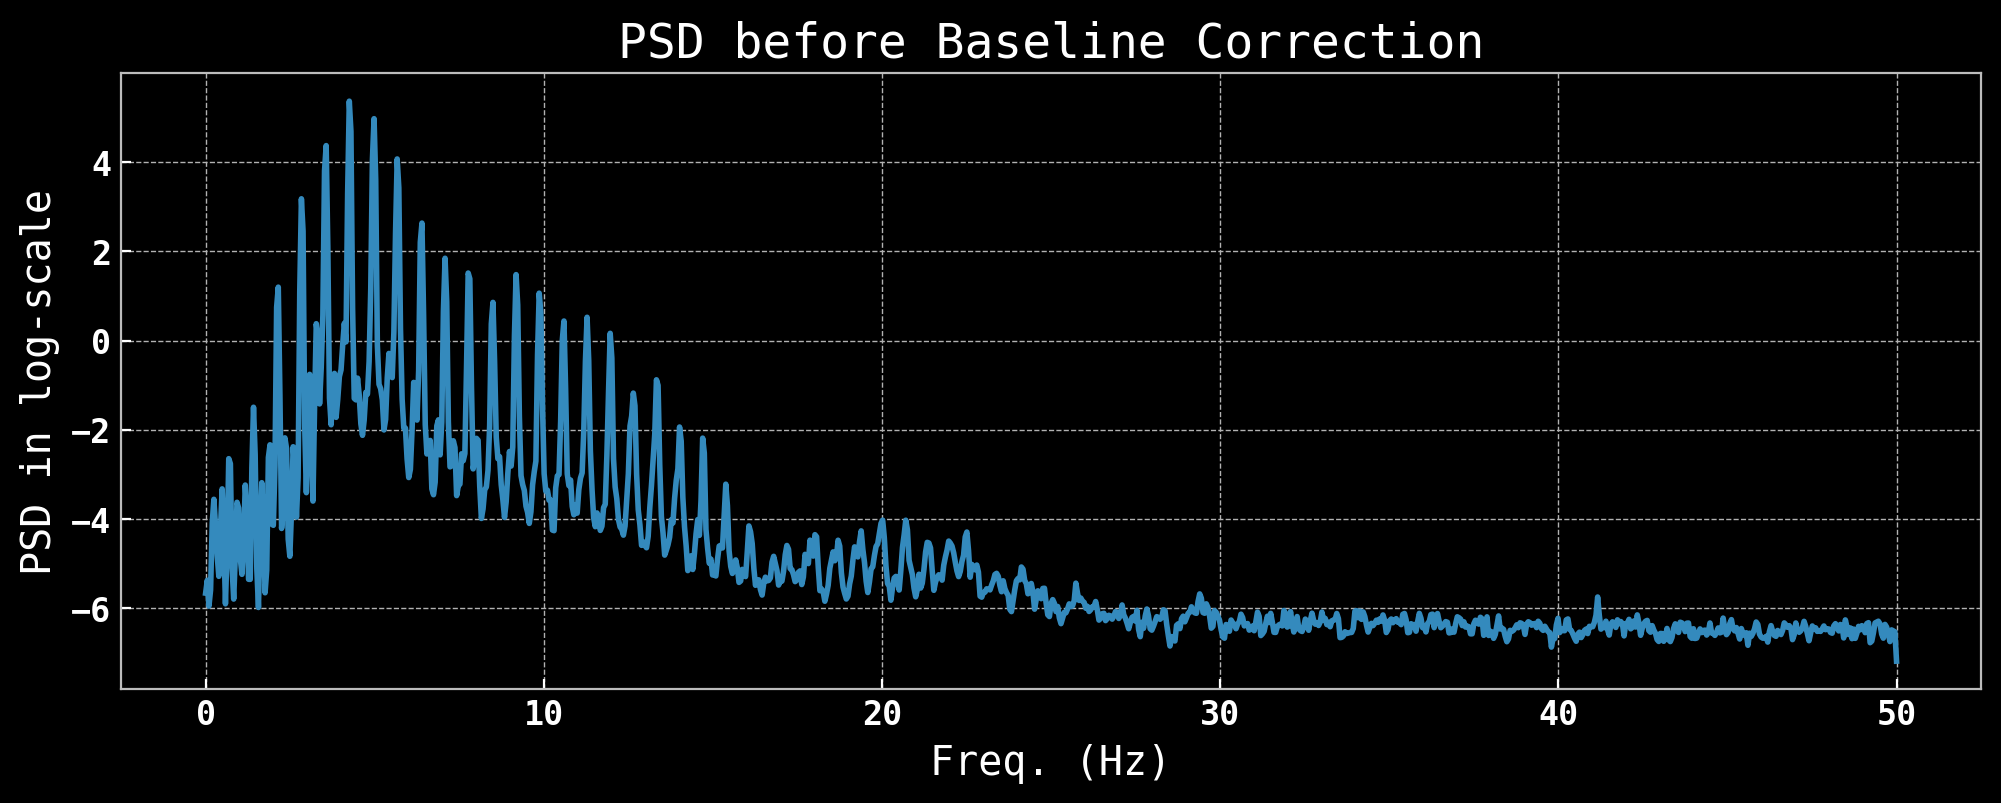

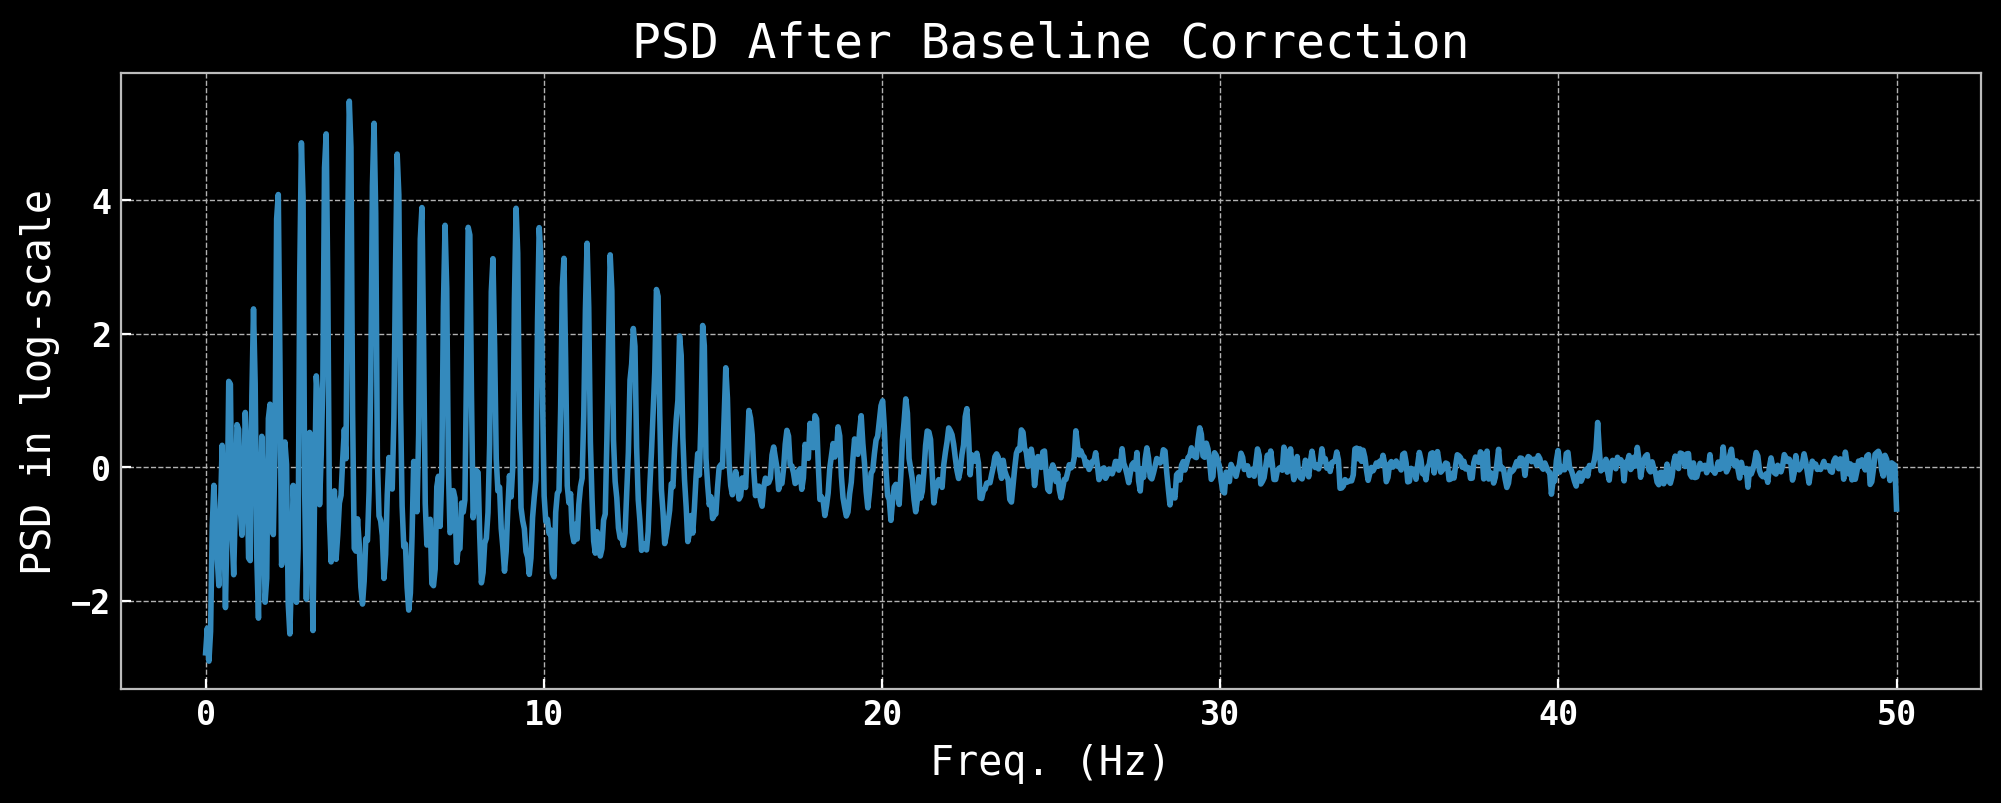

In [15]:
# Plot result
plt.figure(figsize = (12, 4))
plt.plot(f, Pxx_log)
plt.xlabel('Freq. (Hz)')
plt.ylabel('PSD in log-scale')
plt.title('PSD before Baseline Correction')
plt.show()

plt.figure(figsize = (12, 4))
plt.plot(f, Pxx_correct)
plt.xlabel('Freq. (Hz)')
plt.ylabel('PSD in log-scale')
plt.title('PSD After Baseline Correction')
plt.show()

#### **Step #2: Outlier detection using MAD**

In [16]:
def run_MAD(Pxx_correct, alpha = 3):    
    '''
    [Input]
        Pxx_correct : PSD after Baseline removal
        alpha : Significance level

    [Output]
        ind_outlier : Indice of Well-excited peaks
    '''    
    y = Pxx_correct
    x = np.arange(y.shape[0])
    y_med = np.median(y)

    diff_med = np.abs(y - y_med)
    MAD = 1.4826 * np.median(diff_med)
    boolean_outlier = (y_med + MAD * alpha < y)
    ind_outlier = np.argwhere(boolean_outlier == True).squeeze()
    
    return ind_outlier

#### **Run MAD to extract possible Well-excited peaks**

In [25]:
# MAD_ind = run_MAD(Pxx_correct, alpha = 2)
MAD_ind = run_MAD(Pxx_den, alpha = 3)

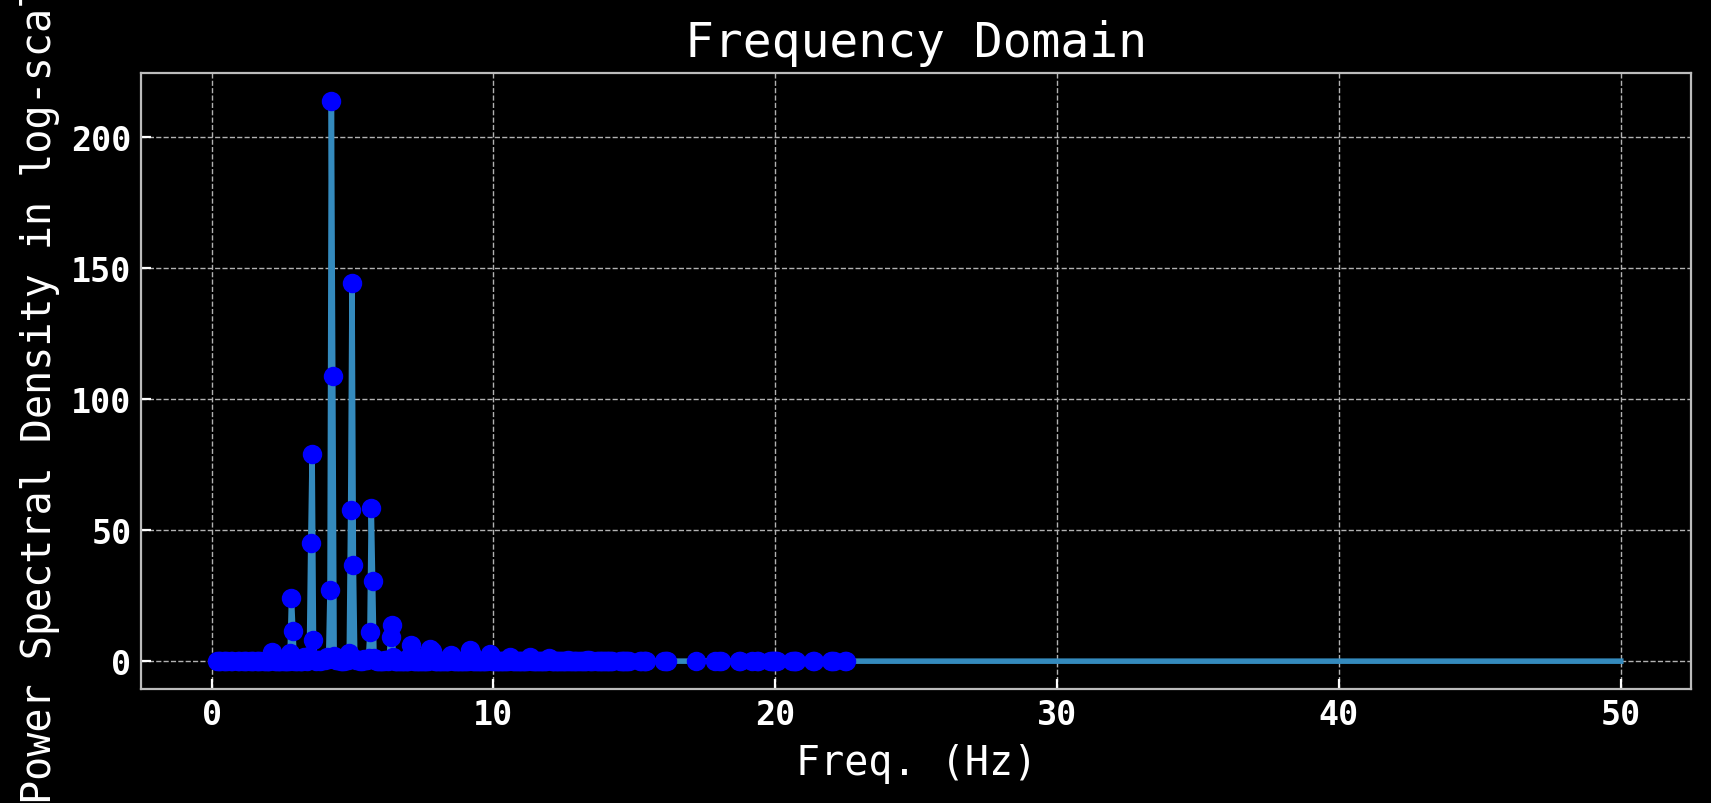

In [26]:
# Plot result
plt.figure(figsize = (10, 4))
# plt.plot(f, Pxx_log)
# plt.plot(f[MAD_ind], Pxx_log[MAD_ind], 'bo')
plt.plot(f, Pxx_den)
plt.plot(f[MAD_ind], Pxx_den[MAD_ind], 'bo')
plt.xlabel('Freq. (Hz)')
plt.ylabel('Power Spectral Density in log-scale')
plt.title('Frequency Domain')
plt.show()

## <span style='color:black'>**4. Information Integration**</span>
### <span style='color:blue'> **_Background #4: Simple Information Integration_**</span>

- By simply integrating the results from two information, we can extract peaks accurately without any prior setting.


<center> <p>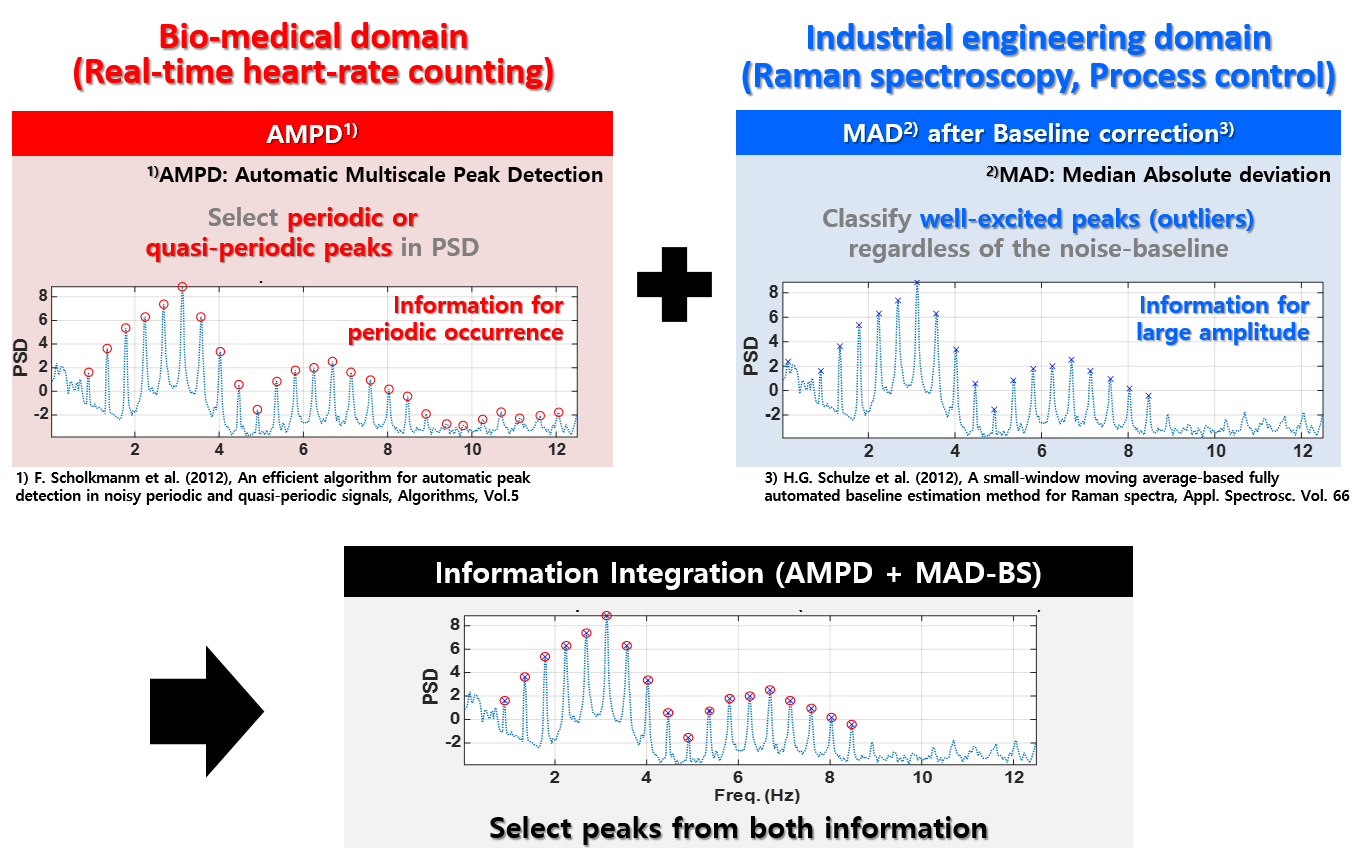</p> </center>

#### **Find peaks selected from both Infromation Sources**

In [27]:
final_ind = np.intersect1d(AMPD_ind, MAD_ind)

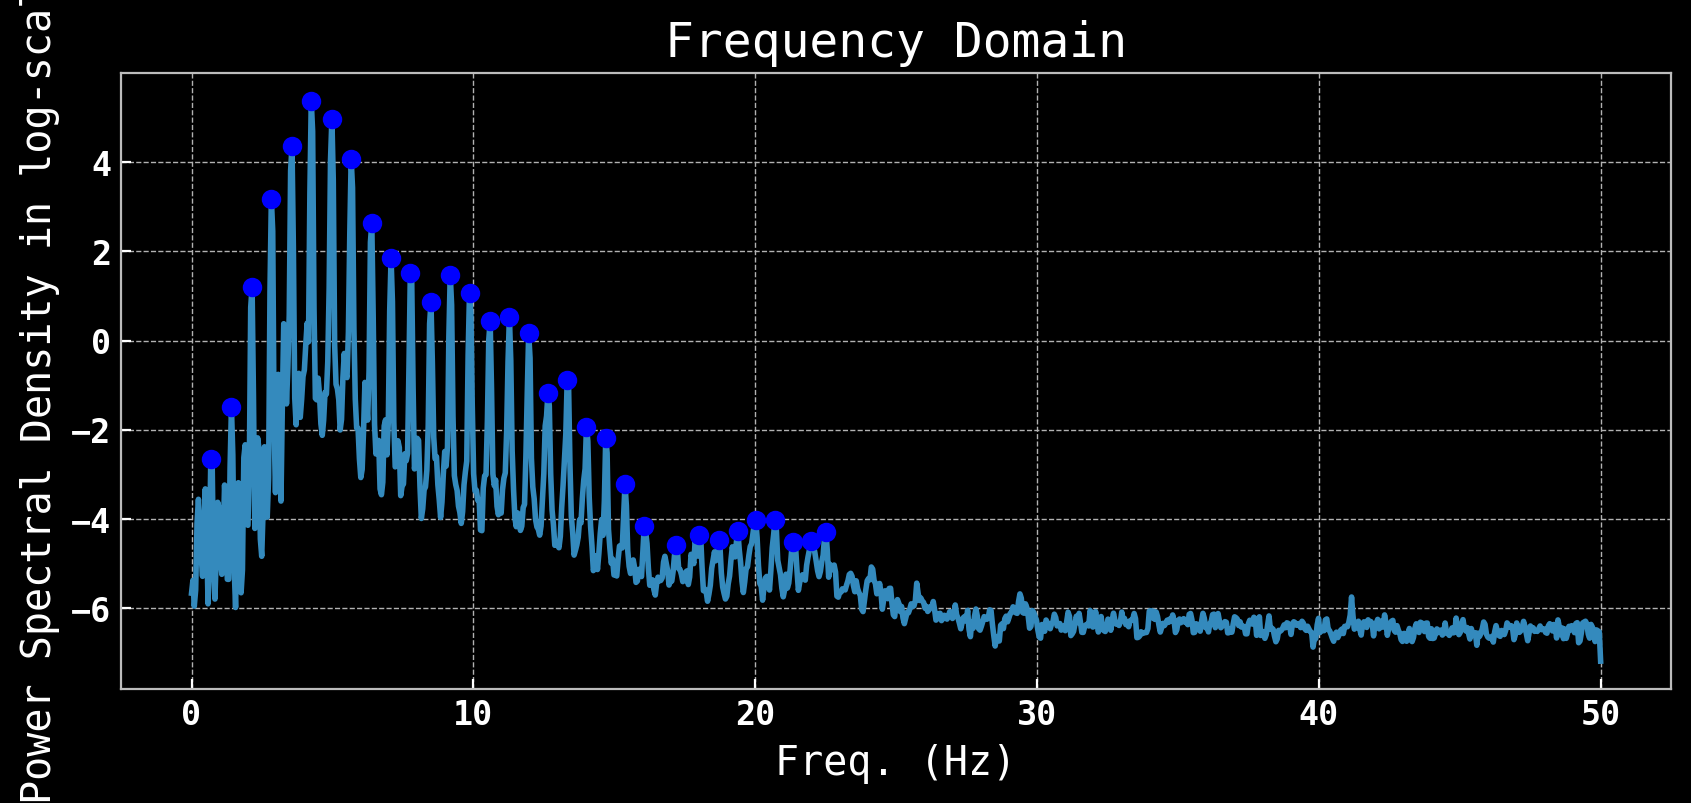

In [28]:
# Plot result
plt.figure(figsize = (10, 4))
plt.plot(f, Pxx_log)
plt.plot(f[final_ind], Pxx_log[final_ind], 'bo')
plt.xlabel('Freq. (Hz)')
plt.ylabel('Power Spectral Density in log-scale')
plt.title('Frequency Domain')
plt.show()